# Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# dataset link : "https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres"

C:\Users\hassa\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\hassa\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


# Dataset Loading

<ipython-input-2-405fecf54f35>:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['NumberOfWords'], kde=False, bins=200)


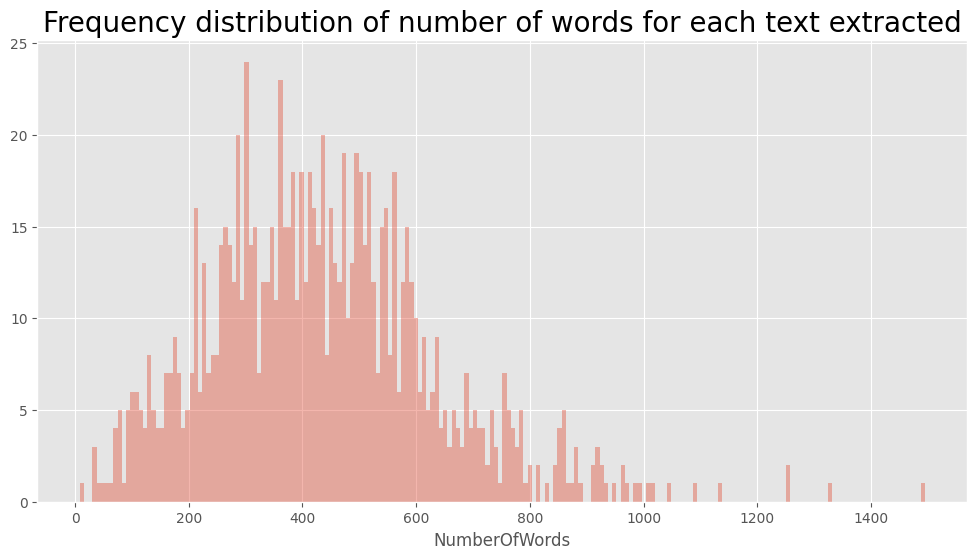

In [2]:
torch.manual_seed(0)
np.random.seed(0)

# Load and preprocess the data
# df = pd.read_csv('C:/Users/hassa/lyrics-data.csv')
# df.drop(['ALink', 'SName', 'SLink'], axis=1, inplace=True)
# df = df[df['language'] == 'en']
# df['NumberOfWords'] = df['Lyric'].apply(lambda x: len(str(x).split()))
# df = df[:1000]
# df.to_csv('C:/Users/hassa/datasets/updated.csv', index=False) # only english song's lyrics
# df['NumberOfWords'].describe()

df = pd.read_csv('C:/Users/hassa/datasets/updated.csv')

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
sns.distplot(df['NumberOfWords'], kde=False, bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)
plt.show()

# Data Loader Class

In [3]:
class LyricsDataset(Dataset):
    def __init__(self, lyrics):
        self.lyrics = lyrics
        self.chars = sorted(set("".join(lyrics)))
        self.char2idx = {char: idx for idx, char in enumerate(self.chars)}
        self.idx2char = {idx: char for idx, char in enumerate(self.chars)}

    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, idx):
        lyric = self.lyrics[idx]
        return torch.tensor([self.char2idx[char] for char in lyric], dtype=torch.long)

dataset = LyricsDataset(df['Lyric'].tolist())
trainLoader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=lambda x: nn.utils.rnn.pad_sequence(x, batch_first=True))
print("Done")

Done


# LSTM Model

In [4]:
class RnnModel(nn.Module):
    def __init__(self, vocabSize, embedSize, hiddenSize, numLayers):
        super(RnnModel, self).__init__()
        self.hiddenSize = hiddenSize
        self.numLayers = numLayers
        self.embedding = nn.Embedding(vocabSize, embedSize)
        self.rnn = nn.LSTM(embedSize, hiddenSize, numLayers, batch_first=True)
        self.fc = nn.Linear(hiddenSize, vocabSize)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        out = out.view(-1, out.size(2))  
        return out, hidden

    def initHidden(self, batchSize):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.numLayers, batchSize, self.hiddenSize).zero_().to(device),
                  weight.new(self.numLayers, batchSize, self.hiddenSize).zero_().to(device))
        return hidden

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocabSize = len(dataset.chars)
embedSize = 128
hiddenSize = 256
numLayers = 2

model = RnnModel(vocabSize, embedSize, hiddenSize, numLayers).to(device)

print(model)

RNNModel(
  (embedding): Embedding(131, 128)
  (rnn): LSTM(128, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=131, bias=True)
)


# Training Model

In [5]:
def train(model, trainLoader, criterion, optimizer, epochs):
    model.train()
    trainLosses = []
    trainAccuracies = []

    for epoch in range(epochs):
        epochLoss = 0
        correctPredictions = 0
        totalPredictions = 0

        for inputs in trainLoader:
            inputs = inputs.to(device)
            batchSize = inputs.size(0)
            h = model.initHidden(batchSize)

            targets = inputs[:, 1:].contiguous().view(-1)
            inputs = inputs[:, :-1]

            h = tuple([e.data for e in h])
            model.zero_grad()
            output, h = model(inputs, h)

            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            epochLoss += loss.item()

            # calculate accuracy
            _, preds = torch.max(output, 1)
            correctPredictions += torch.sum(preds == targets).item()
            totalPredictions += targets.size(0)

        trainLosses.append(epochLoss / len(trainLoader))
        trainAccuracy = correctPredictions / totalPredictions
        trainAccuracies.append(trainAccuracy)
        print(f'Epoch {epoch + 1}, Loss: {epochLoss / len(trainLoader):.4f}, Accuracy: {trainAccuracy:.4f}')

    return trainLosses, trainAccuracies

Epoch 1, Loss: 2.7081, Accuracy: 0.5566
Epoch 2, Loss: 1.4697, Accuracy: 0.6386
Epoch 3, Loss: 1.3801, Accuracy: 0.6575
Epoch 4, Loss: 1.3502, Accuracy: 0.6627
Epoch 5, Loss: 1.3538, Accuracy: 0.6534
Epoch 6, Loss: 1.3241, Accuracy: 0.6543
Epoch 7, Loss: 1.2966, Accuracy: 0.6725
Epoch 8, Loss: 1.1791, Accuracy: 0.6958
Epoch 9, Loss: 1.1593, Accuracy: 0.6992
Epoch 10, Loss: 1.0729, Accuracy: 0.7175
Epoch 11, Loss: 1.0367, Accuracy: 0.7209
Epoch 12, Loss: 1.0000, Accuracy: 0.7301
Epoch 13, Loss: 0.9831, Accuracy: 0.7359
Epoch 14, Loss: 0.9595, Accuracy: 0.7367
Epoch 15, Loss: 0.9144, Accuracy: 0.7505
Epoch 16, Loss: 0.8709, Accuracy: 0.7595
Epoch 17, Loss: 0.8701, Accuracy: 0.7626
Epoch 18, Loss: 0.8750, Accuracy: 0.7604
Epoch 19, Loss: 0.8594, Accuracy: 0.7646
Epoch 20, Loss: 0.8350, Accuracy: 0.7674
Epoch 21, Loss: 0.8238, Accuracy: 0.7695
Epoch 22, Loss: 0.8391, Accuracy: 0.7673
Epoch 23, Loss: 0.8010, Accuracy: 0.7731
Epoch 24, Loss: 0.7738, Accuracy: 0.7802
Epoch 25, Loss: 0.7723, A

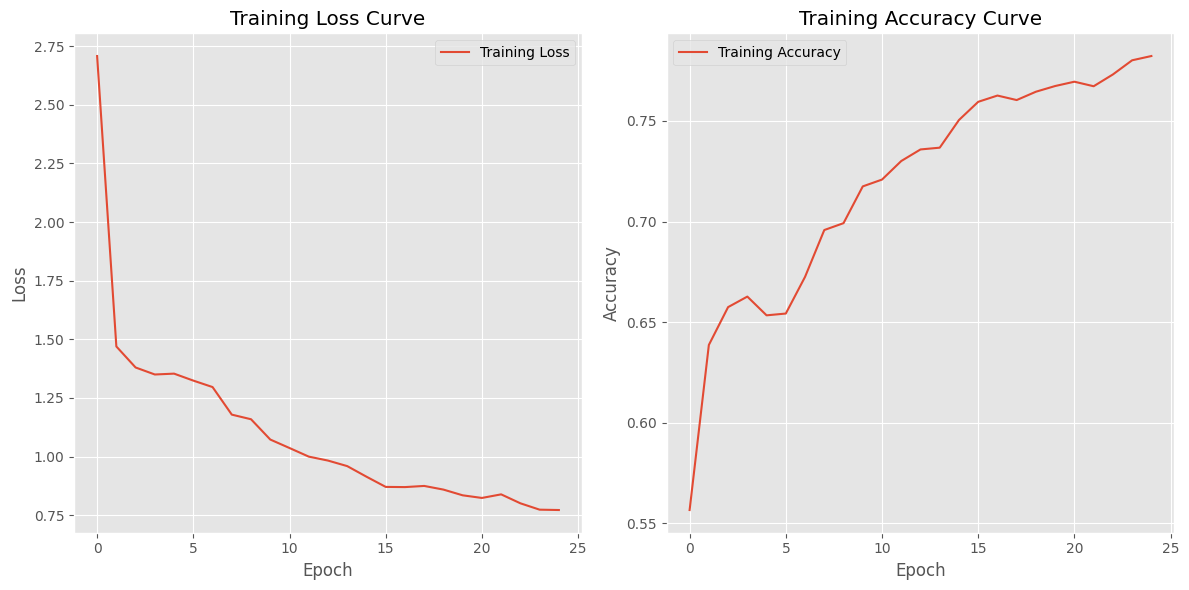

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 25
trainLosses, trainAccuracies = train(model, trainLoader, criterion, optimizer, epochs)

# plotting learning curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(trainLosses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trainAccuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Generate Text To Evaluate Model

In [6]:
def generateText(model, seedText, chars, char2Idx, idx2Char, maxLength=100):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor([char2Idx[char] for char in seedText], dtype=torch.long).unsqueeze(0).to(device)
        h = model.initHidden(1)

        generatedText = seedText
        for _ in range(maxLength):
            output, h = model(inputs, h)
            output = output.squeeze(0)  
            output = output[-1]  # get output from the last timestep
            _, predictedIdx = torch.max(output, dim=0)
            predictedChar = idx2Char[predictedIdx.item()]

            generatedText += predictedChar

            inputs = torch.cat((inputs, predictedIdx.unsqueeze(0).unsqueeze(0)), dim=1)

    return generatedText

seedText = "I feel so"
generatedText = generateText(model, seedText, dataset.chars, dataset.char2Idx, dataset.idx2Char)
print("Generated Text:\n", generatedText)

Generated Text:
 I feel so alone the dark and the rain with whisper that never seem to fade show


Note: This model is not fully trained due to resource limitations. However, I hope the basic architecture of LSTM is demonstrated effectively through this project, as I have done my best.